## Food Scarcity

In [1]:
# Edit all the Mardown cells below with the appropriate information 
# Run all cells, containing your code 
# Save this Jupyter with the outputs of your executed cells
#
# PS: Save again the notebook with this outcome.
# PSPS: Don't forget to include the dataset in your submission

**Team:**
* Dante Osbourne
* Dylan Porter

**Course:** DAAN 897– Deep Learning (Spring, 2024)

### Problem Statement
* As our planet's climate changes over time, food availability will be certainly impacted. This project aims to use deep learning algorithms in conjunction with data on climate change and crop yields to predict future food scarcity.
    
    
    
* **Keywords:** Food Scarcity, Food Scarcity Prediction,Climate Change 
	

### Data Collection
* Source(url): https://www.kaggle.com/datasets/goyaladi/climate-insights-dataset
* Short Description : Collection of various climate related data for various countries such as temperature, CO2 Emissions, Precipitation, etc.

* Keywords: climate insights, climate change, temperature, weather



* Source(url): https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset
* Short Description : Collection of crop yield data and surrounding factors such as average rainfall, average temperature by location

* Keywords: crop yields, temperature, pesticides 

### Required packages

* Keras
* Pandas
* Numpy
* matplotlib
* scikit-learn
*kerastuner


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, InputLayer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kerastuner import RandomSearch

C:\Users\dazzi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\dazzi\AppData\Local\Temp\ipykernel_836\1112039909.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


### Data Preprocessing

Below are the steps we took to preprocess the data for model consumption
* Load the respective datasets into data frames
* Perform basic exploration on the data to see datatypes, check for empty values, check for duplicates, and gather descriptive statistics.
* Examine each data set and check uniqueness for each column
* Extract the year from the date column in the climate insights dataset as that will be needed for proper aggregation
* Detect and remove outliers in the respective datasets to minimize errors upon modeling
* Generate histograms and correlation matrixes of each respective dataset to better understand the data
* Remove irrelevant columns in the respective datasets
* Aggregate the climate insights dataset by year as the crop yield dataset is yearly


In [3]:
# Read in both datasets
climate_change_df = pd.read_csv('./data/climate_change_data.csv')
yield_df = pd.read_csv('./data/yield_df.csv')

In [4]:
# Convert the Date in the climate_change_data.csv to just the year for formatting and eventual data merging
climate_change_df['Date'] = pd.to_datetime(climate_change_df['Date'], errors='coerce')
climate_change_df['Year'] = climate_change_df['Date'].dt.year

In [5]:
#basic exploration of the climate change dataset
climate_change_df.head()

,Date,Location,Country,Temperature,CO2 Emissions,Sea Level Rise,Precipitation,Humidity,Wind Speed,Year
0,2000-01-01 00:00:00.000000000,New Williamtown,Latvia,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000
1,2000-01-01 20:09:43.258325832,North Rachel,South Africa,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300,2000
2,2000-01-02 16:19:26.516651665,West Williamland,French Guiana,27.323718,451.553155,-0.160783,42.697931,96.652600,34.124261,2000
3,2000-01-03 12:29:09.774977497,South David,Vietnam,12.309581,422.404983,-0.475931,5.193341,47.467938,8.554563,2000
4,2000-01-04 08:38:53.033303330,New Scottburgh,Moldova,13.210885,410.472999,1.135757,78.695280,61.789672,8.001164,2000


In [6]:
#descriptive statistics of the climate change dataset
climate_change_df.describe()

,Temperature,CO2 Emissions,Sea Level Rise,Precipitation,Humidity,Wind Speed,Year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14.936034,400.220469,-0.003152,49.881208,49.771302,25.082066,2010.997900
std,5.030616,49.696933,0.991349,28.862417,28.929320,14.466648,6.633634
min,-3.803589,182.131220,-4.092155,0.010143,0.018998,0.001732,2000.000000
25%,11.577991,367.109330,-0.673809,24.497516,24.713250,12.539733,2005.000000
50%,14.981136,400.821324,0.002332,49.818967,49.678412,24.910787,2011.000000
75%,18.305826,433.307905,0.675723,74.524991,75.206390,37.670260,2017.000000
max,33.976956,582.899701,4.116559,99.991900,99.959665,49.997664,2022.000000


In [7]:
#empty check
climate_change_df.isnull().sum(axis = 0)

Date              0
Location          0
Country           0
Temperature       0
CO2 Emissions     0
Sea Level Rise    0
Precipitation     0
Humidity          0
Wind Speed        0
Year              0
dtype: int64

In [8]:
#duplicate check
climate_change_df.duplicated(keep=False)

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [9]:
i = 0
for col in climate_change_df.columns:
    print(col,'has',len(np.unique(climate_change_df.iloc[:,i])),'unique values')
    i+=1

Date has 10000 unique values
Location has 7764 unique values
Country has 243 unique values
Temperature has 10000 unique values
CO2 Emissions has 10000 unique values
Sea Level Rise has 10000 unique values
Precipitation has 10000 unique values
Humidity has 10000 unique values
Wind Speed has 10000 unique values
Year has 23 unique values


<AxesSubplot:>

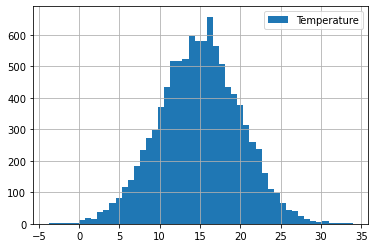

In [10]:
#Temperature histogram generation
climate_change_df.iloc[:,3].hist(legend=True,bins=50)

<AxesSubplot:>

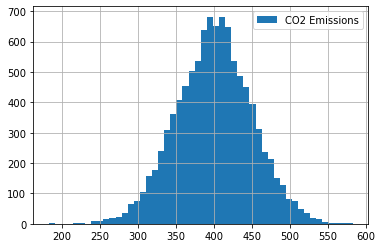

In [11]:
#CO2 histogram generation
climate_change_df.iloc[:,4].hist(legend=True,bins=50)

<AxesSubplot:>

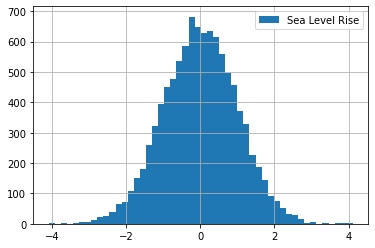

In [12]:
#Sea Level Rise histogram generation
climate_change_df.iloc[:,5].hist(legend=True,bins=50)

<AxesSubplot:>

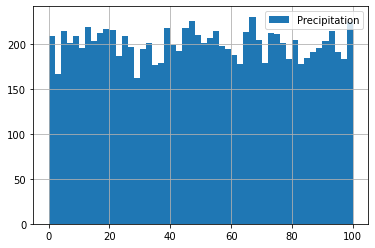

In [13]:
#Precipitation histogram generation
climate_change_df.iloc[:,6].hist(legend=True,bins=50)

<AxesSubplot:>

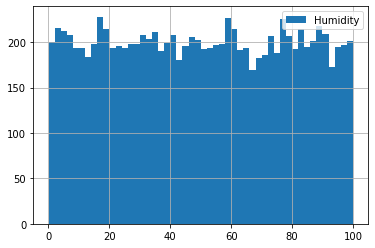

In [14]:
#Humidity histogram generation
climate_change_df.iloc[:,7].hist(legend=True,bins=50)

<AxesSubplot:>

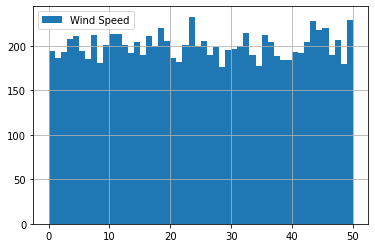

In [15]:
#Wind Speed histogram generation
climate_change_df.iloc[:,8].hist(legend=True,bins=50)

([<matplotlib.axis.YTick at 0x24853cb9ca0>,
 [Text(0, 0, 'Temperature'),
  Text(0, 1, 'CO2 Emissions'),
  Text(0, 2, 'Sea Level Rise'),
  Text(0, 3, 'Precipitation'),
  Text(0, 4, 'Humidity'),
  Text(0, 5, 'Wind Speed'),
  Text(0, 6, 'Year')])

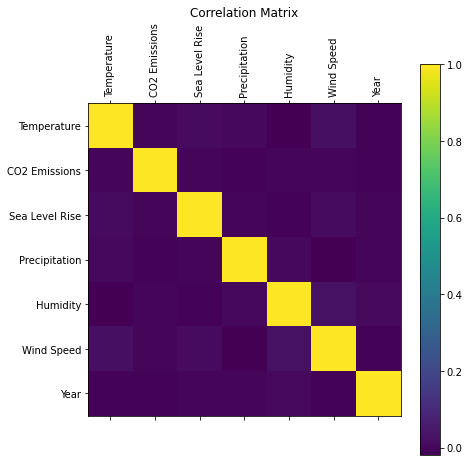

In [16]:
plt.figure(figsize=(7,7))
plt.matshow(climate_change_df.iloc[:,1:].corr(), fignum=1)
plt.title('Correlation Matrix', position = (0.5, 1.1))
plt.colorbar()
plt.xticks(range(7), list(climate_change_df.iloc[:,3:].columns), rotation = 90)
plt.yticks(range(7), list(climate_change_df.iloc[:,3:].columns))

In [17]:
#basic exploration of the yield data frame
yield_df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [18]:
#empty check
yield_df.isnull().sum(axis = 0)

Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [19]:
#duplicate check
yield_df.duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
28237    False
28238    False
28239    False
28240    False
28241    False
Length: 28242, dtype: bool

In [20]:
#descriptive statistics of the yield dataset
yield_df.describe()

,Unnamed: 0,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,14120.500000,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,8152.907488,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,0.000000,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,7060.250000,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,14120.500000,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,21180.750000,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,28241.000000,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [21]:
#remove unnecessary column
climate_change_df = climate_change_df.drop(['Date'], axis=1)

In [22]:
#remove unnecessary column
yield_df = yield_df.drop(['Unnamed: 0'], axis=1)

In [23]:
i = 0
for col in yield_df.columns:
    print(col,'has',len(np.unique(yield_df.iloc[:,i])),'unique values')
    i+=1


Area has 101 unique values
Item has 10 unique values
Year has 23 unique values
hg/ha_yield has 11514 unique values
average_rain_fall_mm_per_year has 100 unique values
pesticides_tonnes has 1673 unique values
avg_temp has 1831 unique values


<AxesSubplot:>

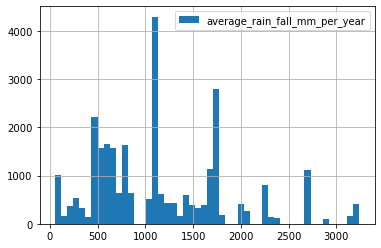

In [24]:
#yield histogram generation
yield_df.iloc[:,4].hist(legend=True,bins=50)

<AxesSubplot:>

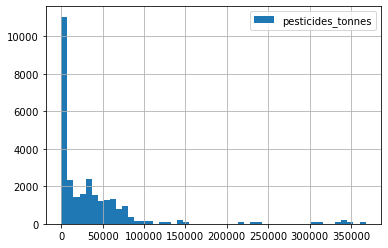

In [25]:
#average rainfall histogram generation
yield_df.iloc[:,5].hist(legend=True,bins=50)

In [26]:
# Need to average the climate change dataset because it is more granular by location when compared to the other datset.
climate_change_df_average = climate_change_df.groupby(['Country', 'Year']).mean(numeric_only=True).reset_index()

In [27]:
# Find all columns that are numeric
climate_change_df_numeric = climate_change_df_average.select_dtypes(include=[np.number])

In [28]:
# Find all columns that are numeric
yield_df_numeric = yield_df.select_dtypes(include=[np.number])

In [29]:
#outlier removal climate change
climate_change_no_outlier = climate_change_df_numeric[(np.abs(stats.zscore(climate_change_df_numeric)) < 3).all(axis=1)]

In [30]:
#outlier removal yield change
yield_df_no_outlier = yield_df_numeric[(np.abs(stats.zscore(yield_df_numeric)) < 3).all(axis=1)]

In [31]:
# Remove all rows that contained outliers
climate_change_df_average = climate_change_df.loc[climate_change_no_outlier.index]

In [32]:
# Remove all rows that contained outliers
yield_df = yield_df.loc[yield_df_no_outlier.index]

In [33]:
yield_df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


([<matplotlib.axis.YTick at 0x24854f416a0>,
 [Text(0, 0, 'Year'),
  Text(0, 1, 'hg/ha_yield'),
  Text(0, 2, 'average_rain_fall_mm_per_year'),
  Text(0, 3, 'pesticides_tonnes'),
  Text(0, 4, 'avg_temp')])

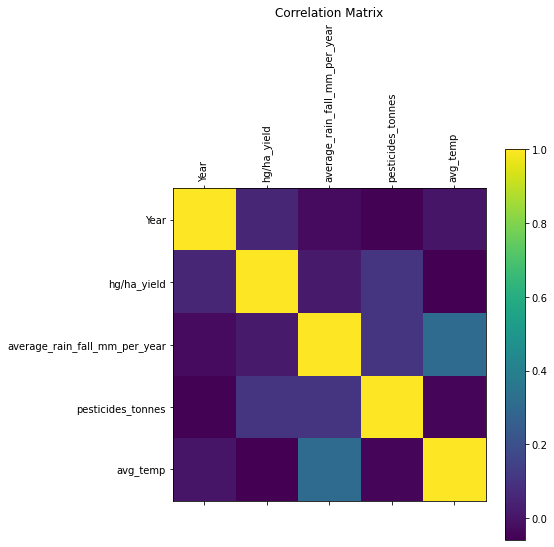

In [34]:
#look if any correlation for possible regression exercises 
plt.figure(figsize=(7,7))
plt.matshow(yield_df.iloc[:,1:].corr(), fignum=1)
plt.title('Correlation Matrix', position = (0.5, 1.1))
plt.colorbar()
plt.xticks(range(5), list(yield_df.iloc[:,2:].columns), rotation = 90)
plt.yticks(range(5), list(yield_df.iloc[:,2:].columns))

In [35]:
#merge dataset
merged_df = pd.merge(climate_change_df_average, yield_df, left_on=['Country', 'Year'], right_on=['Area', 'Year'])

In [36]:
merged_df

,Location,Country,Temperature,CO2 Emissions,Sea Level Rise,Precipitation,Humidity,Wind Speed,Year,Area,Item,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,New Williamtown,Latvia,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000,Latvia,Potatoes,145634,641.0,284.72,7.47
1,New Williamtown,Latvia,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000,Latvia,Wheat,27034,641.0,284.72,7.47
2,Rachelburgh,Latvia,17.355325,275.769689,0.748323,92.541043,50.543222,19.078273,2000,Latvia,Potatoes,145634,641.0,284.72,7.47
3,Rachelburgh,Latvia,17.355325,275.769689,0.748323,92.541043,50.543222,19.078273,2000,Latvia,Wheat,27034,641.0,284.72,7.47
4,North Rachel,South Africa,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300,2000,South Africa,Maize,28492,495.0,26857.00,20.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18430,Graychester,Australia,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,Australia,Wheat,15729,534.0,42169.39,20.33
18431,Graychester,Australia,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,Australia,Wheat,15729,534.0,42169.39,12.37
18432,Graychester,Australia,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,Australia,Wheat,15729,534.0,42169.39,14.23
18433,Graychester,Australia,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,Australia,Wheat,15729,534.0,42169.39,19.09


### Methodology

1. Explan your Deep Learning process / methodology



2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Description 
 
 * Model 2
    * Description
 
 * Ensemble method
     * Description 
 
 
3. Add keywords  
**Keywords:** natural language processing, sentiment analysis, clustering, binary classification, multi-label classification, prediction
	___
 **Example**
* ConvNet
    * A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery(source Wikipedia). 
 
* **Keywords:** supervised learning, classification, ...

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [37]:
# One-hot encode country
X = pd.get_dummies(merged_df, columns=['Country'])

X = pd.get_dummies(X, columns=['Item'])

# X is all the fields that predict hg/ha_yield
X = X.drop('hg/ha_yield', axis=1)
X = X.drop('Location', axis=1)
X = X.drop('Area', axis=1)
Y = merged_df['hg/ha_yield']


In [38]:
X

,Temperature,CO2 Emissions,Sea Level Rise,Precipitation,Humidity,Wind Speed,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000,641.0,284.72,7.47,...,0,0,0,1,0,0,0,0,0,0
1,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000,641.0,284.72,7.47,...,0,0,0,0,0,0,0,0,1,0
2,17.355325,275.769689,0.748323,92.541043,50.543222,19.078273,2000,641.0,284.72,7.47,...,0,0,0,1,0,0,0,0,0,0
3,17.355325,275.769689,0.748323,92.541043,50.543222,19.078273,2000,641.0,284.72,7.47,...,0,0,0,0,0,0,0,0,1,0
4,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300,2000,495.0,26857.00,20.74,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18430,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,534.0,42169.39,20.33,...,0,0,0,0,0,0,0,0,1,0
18431,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,534.0,42169.39,12.37,...,0,0,0,0,0,0,0,0,1,0
18432,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,534.0,42169.39,14.23,...,0,0,0,0,0,0,0,0,1,0
18433,9.085795,434.270722,-2.002027,0.679430,84.277177,28.460437,2010,534.0,42169.39,19.09,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# Standardize the dataset to feed into the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2)


In [41]:
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))

    # Create a variable number of layers between 2 and 5 along with an associated Dropout layer
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Regression so just one unit needed
    model.add(Dense(1))

    # Adjust the learning rate dynamically, go off of val_loss for mean_squared_error
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='mean_squared_error')
    return model

In [42]:
import keras_tuner

model = build_model(keras_tuner.HyperParameters())


In [43]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3840      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
369/369 [==============================] - 1s 1ms/step - loss: 10520730624.0000 - val_loss: 10896495616.0000
Epoch 2/100
369/369 [==============================] - 0s 763us/step - loss: 10519941120.0000 - val_loss: 10895230976.0000
Epoch 3/100
369/369 [==============================] - 0s 756us/step - loss: 10518020096.0000 - val_loss: 10892430336.0000
Epoch 4/100
369/369 [==============================] - 0s 757us/step - loss: 10514317312.0000 - val_loss: 10887538688.0000
Epoch 5/100
369/369 [==============================] - 0s 754us/step - loss: 10508306432.0000 - val_loss: 10880054272.0000
Epoch 6/100
369/369 [==============================] - 0s 756us/step - loss: 10499611648.0000 - val_loss: 10869730304.0000
Epoch 7/100
369/369 [==============================] - 0s 760us/step - loss: 10487960576.0000 - val_loss: 10856306688.0000
Epoch 8/100
369/369 [==============================] - 0s 763us/step - loss: 10473278464.0000 - val_loss: 10839717888.0000
Epoch 9/100
369/36

Epoch 68/100
369/369 [==============================] - 0s 762us/step - loss: 2990348800.0000 - val_loss: 3107752960.0000
Epoch 69/100
369/369 [==============================] - 0s 754us/step - loss: 2862512640.0000 - val_loss: 2975620864.0000
Epoch 70/100
369/369 [==============================] - 0s 752us/step - loss: 2741019392.0000 - val_loss: 2850333184.0000
Epoch 71/100
369/369 [==============================] - 0s 757us/step - loss: 2625837056.0000 - val_loss: 2731436800.0000
Epoch 72/100
369/369 [==============================] - 0s 760us/step - loss: 2517253888.0000 - val_loss: 2618440960.0000
Epoch 73/100
369/369 [==============================] - 0s 753us/step - loss: 2415403520.0000 - val_loss: 2512655872.0000
Epoch 74/100
369/369 [==============================] - 0s 761us/step - loss: 2320925184.0000 - val_loss: 2414147072.0000
Epoch 75/100
369/369 [==============================] - 0s 760us/step - loss: 2233372416.0000 - val_loss: 2323529728.0000
Epoch 76/100
369/369 [==

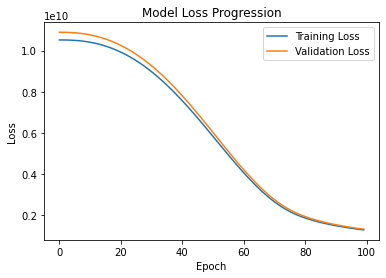

In [44]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [45]:
# Find the optimal hyperparameters via keras tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=160,
    executions_per_trial=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Reloading Tuner from .\untitled_project\tuner0.json


In [46]:
tuner.search(X_train, Y_train, validation_split=0.2, epochs=20, batch_size=32)
best_model = tuner.get_best_models(num_models=1)[0]


In [47]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 004 summary
Hyperparameters:
num_layers: 4
units_0: 320
dropout_0: 0.0
units_1: 128
dropout_1: 0.0
learning_rate: 0.0034928656354620575
units_2: 288
dropout_2: 0.2
units_3: 480
dropout_3: 0.2
units_4: 448
dropout_4: 0.0
Score: 96802616.0

Trial 039 summary
Hyperparameters:
num_layers: 2
units_0: 384
dropout_0: 0.0
units_1: 512
dropout_1: 0.0
learning_rate: 0.00332265556312533
units_2: 320
dropout_2: 0.30000000000000004
units_3: 288
dropout_3: 0.4
units_4: 512
dropout_4: 0.30000000000000004
Score: 109715776.0

Trial 106 summary
Hyperparameters:
num_layers: 5
units_0: 416
dropout_0: 0.0
units_1: 448
dropout_1: 0.0
learning_rate: 0.0031727195992059948
units_2: 512
dropout_2: 0.2
units_3: 224
dropout_3: 0.1
units_4: 320
dropout_4: 0.30000000000000004
Score: 109956712.0

Trial 045 summary
Hyperparameters:
num_layers: 5
units_0: 480
dropout_0: 0.0
units_1: 512
dropout_1: 0.

Epoch 1/100
369/369 [==============================] - 2s 3ms/step - loss: 2155483904.0000 - val_loss: 584082880.0000
Epoch 2/100
369/369 [==============================] - 1s 3ms/step - loss: 371413856.0000 - val_loss: 260312656.0000
Epoch 3/100
369/369 [==============================] - 1s 3ms/step - loss: 218117824.0000 - val_loss: 156299296.0000
Epoch 4/100
369/369 [==============================] - 1s 3ms/step - loss: 178300800.0000 - val_loss: 178334176.0000
Epoch 5/100
369/369 [==============================] - 1s 3ms/step - loss: 161883392.0000 - val_loss: 139503232.0000
Epoch 6/100
369/369 [==============================] - 1s 3ms/step - loss: 149127280.0000 - val_loss: 129093288.0000
Epoch 7/100
369/369 [==============================] - 1s 3ms/step - loss: 124687432.0000 - val_loss: 106003984.0000
Epoch 8/100
369/369 [==============================] - 1s 3ms/step - loss: 134011768.0000 - val_loss: 121732376.0000
Epoch 9/100
369/369 [==============================] - 1s 3ms/s

369/369 [==============================] - 1s 3ms/step - loss: 45258240.0000 - val_loss: 79229808.0000
Epoch 72/100
369/369 [==============================] - 1s 3ms/step - loss: 45000548.0000 - val_loss: 62647164.0000
Epoch 73/100
369/369 [==============================] - 1s 3ms/step - loss: 46591416.0000 - val_loss: 74284960.0000
Epoch 74/100
369/369 [==============================] - 1s 3ms/step - loss: 44872764.0000 - val_loss: 79645488.0000
Epoch 75/100
369/369 [==============================] - 1s 3ms/step - loss: 43994248.0000 - val_loss: 68764456.0000
Epoch 76/100
369/369 [==============================] - 1s 3ms/step - loss: 44036416.0000 - val_loss: 71052304.0000
Epoch 77/100
369/369 [==============================] - 1s 3ms/step - loss: 41895192.0000 - val_loss: 88560872.0000
Epoch 78/100
369/369 [==============================] - 1s 3ms/step - loss: 45227280.0000 - val_loss: 80125264.0000
Epoch 79/100
369/369 [==============================] - 1s 3ms/step - loss: 47366712.

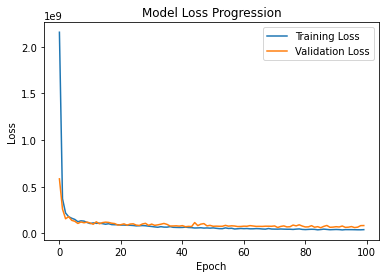

In [48]:
# Best model based on keras tuner
model = Sequential()

model.add(Dense(320, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.0))

model.add(Dense(288, activation='relu', kernel_regularizer=l1(0.1)))
model.add(Dropout(0.2))
model.add(Dense(480, activation='relu', kernel_regularizer=l1(0.1)))
model.add(Dropout(0.2))
model.add(Dense(448, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [49]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 320)               38400     
                                                                 
 dense_6 (Dense)             (None, 128)               41088     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 288)               37152     
                                                                 
 dropout_5 (Dropout)         (None, 288)               0         
                                                                 
 dense_8 (Dense)             (None, 480)               138720    
                                                                 
 dropout_6 (Dropout)         (None, 480)              

### Issues / Improvements
1. Dataset is very small
2. Use regularization / initialization
3. Use cross-validaiton
4. ...

###  References
   - Academic (if any)
   - Online (if any)
	

### Credits

- If you use and/or adapt your code from existing projects, you must provide links and acknowldge the authors. Keep in mind that all documents in your projects and code will be check against the official plagiarism detection tool used by Penn State ([Turnitin](https://turnitin.psu.edu))

> *This code is based on .... (if any)*

In [50]:
list(X.columns.values)

['Temperature',
 'CO2 Emissions',
 'Sea Level Rise',
 'Precipitation',
 'Humidity',
 'Wind Speed',
 'Year',
 'average_rain_fall_mm_per_year',
 'pesticides_tonnes',
 'avg_temp',
 'Country_Albania',
 'Country_Algeria',
 'Country_Angola',
 'Country_Argentina',
 'Country_Armenia',
 'Country_Australia',
 'Country_Austria',
 'Country_Azerbaijan',
 'Country_Bahamas',
 'Country_Bahrain',
 'Country_Bangladesh',
 'Country_Belarus',
 'Country_Belgium',
 'Country_Botswana',
 'Country_Brazil',
 'Country_Bulgaria',
 'Country_Burkina Faso',
 'Country_Burundi',
 'Country_Cameroon',
 'Country_Canada',
 'Country_Central African Republic',
 'Country_Chile',
 'Country_Colombia',
 'Country_Croatia',
 'Country_Denmark',
 'Country_Dominican Republic',
 'Country_Ecuador',
 'Country_Egypt',
 'Country_El Salvador',
 'Country_Eritrea',
 'Country_Estonia',
 'Country_Finland',
 'Country_France',
 'Country_Germany',
 'Country_Ghana',
 'Country_Greece',
 'Country_Guatemala',
 'Country_Guinea',
 'Country_Guyana',
 'C

In [51]:
X.head()

,Temperature,CO2 Emissions,Sea Level Rise,Precipitation,Humidity,Wind Speed,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,...,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
0,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000,641.0,284.72,7.47,...,0,0,0,1,0,0,0,0,0,0
1,10.688986,403.118903,0.717506,13.835237,23.631256,18.492026,2000,641.0,284.72,7.47,...,0,0,0,0,0,0,0,0,1,0
2,17.355325,275.769689,0.748323,92.541043,50.543222,19.078273,2000,641.0,284.72,7.47,...,0,0,0,1,0,0,0,0,0,0
3,17.355325,275.769689,0.748323,92.541043,50.543222,19.078273,2000,641.0,284.72,7.47,...,0,0,0,0,0,0,0,0,1,0
4,13.814430,396.663499,1.205715,40.974084,43.982946,34.249300,2000,495.0,26857.00,20.74,...,0,1,0,0,0,0,0,0,0,0


In [52]:
Brazil_Predict = [10.5,
400,
0.5,
59,
26,
20,
2030,
500,
500,
13,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,
0
]

In [53]:
Brazil_Predict = pd.DataFrame(Brazil_Predict)
Brazil_scaled = scaler.fit_transform(Brazil_Predict.transpose())

In [54]:
model.predict(Brazil_scaled)

1/1 [==============================] - 0s 65ms/step


array([[3328.3003]], dtype=float32)

In [55]:
# End of Project